In [1]:
import numpy as np
import math
import pandas as pd
import hashlib, random
from sklearn.mixture import GaussianMixture
import copy
import itertools
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import jsonpickle
from random import shuffle
from collections import defaultdict
import os, json
from datetime import datetime
import matplotlib.ticker as mticker
from matplotlib.ticker import MaxNLocator
pd.options.display.float_format = '{:,.2f}'.format
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import random, json
from tqdm import trange, tqdm
from operator import itemgetter
from analyzer import *
# import query_gen

# sns.set(style='ticks', palette='coolwarm') #this overwrites matplotlib setting so make it run first 
sns.set(style='ticks', palette='Paired') #this overwrites matplotlib setting so make it run first 

# def set_font():
import matplotlib
# http://ishxiao.com/blog/python/2017/07/23/how-to-change-the-font-size-on-a-matplotlib-plot.html

font = {'weight' : 'bold',
#         'size'   : 20,
       'family': 'Linux Libertine O'}
matplotlib.rc('font', **font)

In [59]:
#Deepdb 50\% relative error, csv can be find in results/deepdbtaxi, also check deepdb.ipynb
deepdb={
1: 0,
2: 0,
3: 0.22497485777035364,
4: 0.24481150613554234,
5: 0.33369246744670833,
6: 0.3310744986834756,
7: 0.32936472933060196,
8: 0.3307864951564559,
9: 0.2923331575981733,
}

#DeepDB training cost, in seconds:
deepdbcost={
1: 39,
2: 40,
3: 48,
4: 47,
5: 49,
6: 51,
7: 50,
8: 50,
9: 51,
}
#DeepDB latency:
deeplatency=[
0.012469037633331027,
0.012030397298221942,
0.013770206679478265,
0.012087977092713118,
0.01298266895324923,
0.013189187979442067,
0.013784133938548621,
0.013806879842130002,
0.012652351679687854,
]
deeplatency = {i:x*1000 for i, x in enumerate(deeplatency)}

In [4]:
deeplatency

{0: 12.469037633331027,
 1: 12.030397298221942,
 2: 13.770206679478266,
 3: 12.087977092713118,
 4: 12.982668953249231,
 5: 13.189187979442067,
 6: 13.78413393854862,
 7: 13.806879842130002,
 8: 12.652351679687854}

In [51]:
#Initialization cost of PASS, in ms
#cd /home/xiliang/COMPASS/notebooks/results/etfND/repartitionNDPara/log
#ls -v *.log|xargs grep ms|grep -e KD -e catchup
# partitioning + catching up. this is for parallel catchup cost
passcost={
1:    4725+1250,
2:    5066+3380,
3: 4644+5217,
4: 4868+7548,
5: 4858+9248,
6: 4883+10884,
7: 5139+13014,
8: 4904+16002,
9: 5164+17738,
}
for k, v in passcost.items():
    passcost[k] = v/1000;
print(passcost)

{1: 5.975, 2: 8.446, 3: 9.861, 4: 12.416, 5: 14.106, 6: 15.767, 7: 18.153, 8: 20.906, 9: 22.902}


In [94]:
costs={
    "JanusAQP": passcost,
    "DeepDB": deepdbcost
}

In [48]:
passfiles=[
"compass.PASS_open-close-low-high-idate_volume_1024-1X-0.01-3957-0.1-395713-2000.csv",
"compass.PASS_open-close-low-high-idate_volume_1024-1X-0.01-7914-0.1-791426-2000.csv",
"compass.PASS_open-close-low-high-idate_volume_1024-1X-0.01-11871-0.1-1187139-2000.csv",
"compass.PASS_open-close-low-high-idate_volume_1024-1X-0.01-15828-0.1-1582852-2000.csv",
"compass.PASS_open-close-low-high-idate_volume_1024-1X-0.01-19785-0.1-1978565-2000.csv",
"compass.PASS_open-close-low-high-idate_volume_1024-1X-0.01-23742-0.1-2374278-2000.csv",
"compass.PASS_open-close-low-high-idate_volume_1024-1X-0.01-27699-0.1-2769991-2000.csv",
"compass.PASS_open-close-low-high-idate_volume_1024-1X-0.01-31657-0.1-3165704-2000.csv",
"compass.PASS_open-close-low-high-idate_volume_1024-1X-0.01-35614-0.1-3561417-2000.csv",
"compass.PASS_open-close-low-high-idate_volume_1024-1X-0.01-39571-0.1-3957130-2000.csv",
]
rsfiles=[
"compass.ReservoirSampling_open-close-low-high-idate_volume-3957-0.01-395716-2000.csv",
"compass.ReservoirSampling_open-close-low-high-idate_volume-7914-0.01-791432-2000.csv",
"compass.ReservoirSampling_open-close-low-high-idate_volume-11871-0.01-1187148-2000.csv",
"compass.ReservoirSampling_open-close-low-high-idate_volume-15828-0.01-1582864-2000.csv",
"compass.ReservoirSampling_open-close-low-high-idate_volume-19785-0.01-1978580-2000.csv",
"compass.ReservoirSampling_open-close-low-high-idate_volume-23742-0.01-2374296-2000.csv",
"compass.ReservoirSampling_open-close-low-high-idate_volume-27700-0.01-2770012-2000.csv",
"compass.ReservoirSampling_open-close-low-high-idate_volume-31657-0.01-3165728-2000.csv",
"compass.ReservoirSampling_open-close-low-high-idate_volume-35614-0.01-3561444-2000.csv",
"compass.ReservoirSampling_open-close-low-high-idate_volume-39571-0.01-3957160-2000.csv",
]
pass128=[
"compass.PASS_open-close-low-high-idate_volume_256-1X-0.01-3957-0.1-395713-2000.csv",
"compass.PASS_open-close-low-high-idate_volume_256-1X-0.01-7914-0.1-791426-2000.csv",
"compass.PASS_open-close-low-high-idate_volume_256-1X-0.01-11871-0.1-1187139-2000.csv",
"compass.PASS_open-close-low-high-idate_volume_256-1X-0.01-15828-0.1-1582852-2000.csv",
"compass.PASS_open-close-low-high-idate_volume_256-1X-0.01-19785-0.1-1978565-2000.csv",
"compass.PASS_open-close-low-high-idate_volume_256-1X-0.01-23742-0.1-2374278-2000.csv",
"compass.PASS_open-close-low-high-idate_volume_256-1X-0.01-27699-0.1-2769991-2000.csv",
"compass.PASS_open-close-low-high-idate_volume_256-1X-0.01-31657-0.1-3165704-2000.csv",
"compass.PASS_open-close-low-high-idate_volume_256-1X-0.01-35614-0.1-3561417-2000.csv",
"compass.PASS_open-close-low-high-idate_volume_256-1X-0.01-39571-0.1-3957130-2000.csv"
]
rpass=[
"compass.PASS_open-close-low-high-idate_volume_256-1X-0.01-3957-0.1-395713-2000.csv",
"compass.PASS_open-close-low-high-idate_volume_256-1X-0.01-7914-0.1-791426-2000.csv",
"compass.PASS_open-close-low-high-idate_volume_256-1X-0.01-11871-0.1-1187139-2000.csv",
"compass.PASS_open-close-low-high-idate_volume_256-1X-0.01-15828-0.1-1582853-2000.csv",
"compass.PASS_open-close-low-high-idate_volume_256-1X-0.01-19785-0.1-1978566-2000.csv",
"compass.PASS_open-close-low-high-idate_volume_256-1X-0.01-23742-0.1-2374279-2000.csv",
"compass.PASS_open-close-low-high-idate_volume_256-1X-0.01-27699-0.1-2769993-2000.csv",
"compass.PASS_open-close-low-high-idate_volume_256-1X-0.01-31657-0.1-3165706-2000.csv",
"compass.PASS_open-close-low-high-idate_volume_256-1X-0.01-35614-0.1-3561419-2000.csv1"
]
paracatch=[
"compass.PASS_open-close-low-high-idate_volume_256-1X-0.01-3957-0.1-395713-2000.csv",
"compass.PASS_open-close-low-high-idate_volume_256-1X-0.01-7914-0.1-791426-2000.csv",
"compass.PASS_open-close-low-high-idate_volume_256-1X-0.01-11871-0.1-1187139-2000.csv",
"compass.PASS_open-close-low-high-idate_volume_256-1X-0.01-15828-0.1-1582853-2000.csv",
"compass.PASS_open-close-low-high-idate_volume_256-1X-0.01-19785-0.1-1978566-2000.csv",
"compass.PASS_open-close-low-high-idate_volume_256-1X-0.01-23742-0.1-2374279-2000.csv",
"compass.PASS_open-close-low-high-idate_volume_256-1X-0.01-27699-0.1-2769993-2000.csv",
"compass.PASS_open-close-low-high-idate_volume_256-1X-0.01-31657-0.1-3165706-2000.csv",
"compass.PASS_open-close-low-high-idate_volume_256-1X-0.01-35614-0.1-3561419-2000.csv",
]
prefix='results/etfND/nd1024/csv/'
prefix128="results/etfND/repartitionNDPara/csv/"
ps = {}
rs = {}
# p128=
for i in range(1, 10):
    p = 0.1*i
    ps[i] = pd.read_csv(prefix128+paracatch[i-1])
    rs[i] = pd.read_csv(prefix+rsfiles[i-1])
    if 'qhash' not in rs[i].columns:
        rs[i]['qhash'] = rs[i]['query']
ogt = json.load(open('groundtruths/etf-percentage.json'))
gt = {}
for k,v in ogt.items():
    gt[int(float(k)*10)] = ogt[k]


In [10]:
hashq = {}
for i in range(ps[1].shape[0]):
    r = ps[1].iloc[i]
    hashq[r['qhash']] = r['query']

In [27]:
def get_percentile_re(hashq, baseline, gtp, qtype, percentile):
    qtypeid={'cnt':1, 'sum':0, 'avg': 2}
    re = []
    for i in range(baseline.shape[0]):
        r = baseline.iloc[i]
        q = hashq[r['qhash']]
        gtv = gtp[q][qtypeid[qtype]]
        if gtv == 0:
            re.append(0)
            continue
#         print(r, gtv, q)
        re.append(abs(r[qtype] - gtv)/gtv)
#     print(re)
    return np.percentile(re, percentile)

def getre(p, g, ps=[25, 50, 95], qtype="sum"):
    hashq = {}
    for i in range(p.shape[0]):
        r = p.iloc[i]
        hashq[r['qhash']] = r['query']
    for per in ps:
        print("P", per, "PASS:", get_percentile_re(hashq, p, g, qtype, per))

In [28]:
get_percentile_re(hashq, ps[1], gt[1], 'sum', 50)

0.0

In [50]:
percentile=50
qtype='sum'
passre = {}
rsre = {}

for k in range(1, 10):
    p = ps[k]
    r = rs[k]
    g = gt[k]
    passre[k] = get_percentile_re(hashq, p, g, qtype, percentile)
    rsre[k] = get_percentile_re(hashq, r, g, qtype, percentile)
    print(k, "P", percentile, "RS:", get_percentile_re(hashq, r, g, qtype, percentile))
    print(k, "P", percentile, "DPASS:", get_percentile_re(hashq, p, g, qtype, percentile))
#     for 
# print(passre, "\n", rsre)


1 P 50 RS: 0.0
1 P 50 DPASS: 0.0
2 P 50 RS: 0.0
2 P 50 DPASS: 0.0
3 P 50 RS: 0.00653739631164268
3 P 50 DPASS: 0.002958626589022206
4 P 50 RS: 0.13401549653454864
4 P 50 DPASS: 0.032215978064803044
5 P 50 RS: 0.21768016629240317
5 P 50 DPASS: 0.04397860595797476
6 P 50 RS: 0.2907720539618775
6 P 50 DPASS: 0.059046631724681914
7 P 50 RS: 0.36117898416574196
7 P 50 DPASS: 0.05809852269701739
8 P 50 RS: 0.35873757913676824
8 P 50 DPASS: 0.05918789676698686
9 P 50 RS: 0.347772608135273
9 P 50 DPASS: 0.07408778021338161


In [90]:
baseperf={
    "JanusAQP": passre,
#     "ReservoirSampling": rsre,
    "DeepDB": deepdb
}

In [96]:
def linesubplot(ax, results, ticks, xlabel, ylabel):
    patterns = [ "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*" ]
    markers = ['o', '^', '*', 'v', 'd', 'X', 'P', 'p', '4']
    linestyles= [':', '-.', '--', '-']

    font_size = 25
    xfont = {'weight' : 'bold',
            'size'   : font_size}
    width = 0.6
    our_color = "#3498db"
    baseline_color = "#95a5a6"

    baseline_perf = results
    results = list(baseline_perf.values())[0]
    x_labels = [x*2 for x in results.keys()]

    line_count = -1
    style = defaultdict(dict)

    idx = 0
    for legend, perf in baseline_perf.items():
        perf = list(perf.values())[2:]
        color = our_color if ('AQP' in legend) else baseline_color
        ax.plot(perf, label=legend, marker=markers[idx],  c = color, mfc = 'black', lw = 3, ms = 15)
        idx += 1

    ax.set_xticks(np.arange(len(ticks)))
    ax.set_xticklabels(ticks, fontsize=font_size-5)

    ax.legend(fontsize=20)

    ax.set_ylabel(ylabel, fontdict = xfont)
    ax.set_xlabel(xlabel, fontdict = xfont)
    ax.yaxis.set_tick_params(labelsize=font_size)

def kbarsubplot(ax, results, ticks, xlabel, ylabel, yrange=None):
    x = np.arange(len(ticks))  # the label locations
    patterns = [ "/" , "\\" , "x" , "*", "o", "O", "." ]
    font_size = 25
    xfont = {'weight' : 'bold',
            'size'   : font_size}
    our_color = "#3498db"
    baseline_color = "#95a5a6"
    
    width = 0.25  # the width of the bars
    labels = range(1, len(ticks)+1)

    k = 0
    for leg, d in results.items():
        bar = list(d.values())[2:]
        print(bar)
        rects = ax.bar(x - width/2 + k*width, bar, width, label=leg, hatch=patterns[k])#, color=baseline_color)
        k+= 1
#         rects2 = ax.bar(x + width/2, bar2, width, label=leg2, hatch=patterns[1])#, color=our_color)

    ax.set_xticks(np.arange(len(ticks)))
    ax.set_xticklabels(ticks, fontsize=font_size-5)
#     ax.set_yscale('log')
    if yrange:
        ax.set_ylim(*yrange)
    ax.legend(fontsize=20)

    ax.set_ylabel(ylabel, fontdict = xfont)
    ax.set_xlabel(xlabel, fontdict = xfont)
    ax.yaxis.set_tick_params(labelsize=font_size)
    
    
def plot2(leftargs, leftfunc, rightargs, rightfunc, title = None, fname = None):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    font_size = 25
    xfont = {'weight' : 'bold',
            'size'   : font_size}
    our_color = "#3498db"
    baseline_color = "#95a5a6"

    leftargs['ax'] = axs[0]
    leftfunc(**leftargs)
    
    rightargs['ax'] = axs[1]
    rightfunc(**rightargs)

    fig.tight_layout()
    plt.show()
    if fname:
        fig.savefig("figures/"+fname+".pdf", bbox_inches='tight')

In [92]:
baseperf

{'JanusAQP': {1: 0.0,
  2: 0.0,
  3: 0.002958626589022206,
  4: 0.032215978064803044,
  5: 0.04397860595797476,
  6: 0.059046631724681914,
  7: 0.05809852269701739,
  8: 0.05918789676698686,
  9: 0.07408778021338161},
 'DeepDB': {1: 0,
  2: 0,
  3: 0.22497485777035364,
  4: 0.24481150613554234,
  5: 0.33369246744670833,
  6: 0.3310744986834756,
  7: 0.32936472933060196,
  8: 0.3307864951564559,
  9: 0.2923331575981733}}

[9.861, 12.416, 14.106, 15.767, 18.153, 20.906, 22.902]
[48, 47, 49, 51, 50, 50, 51]


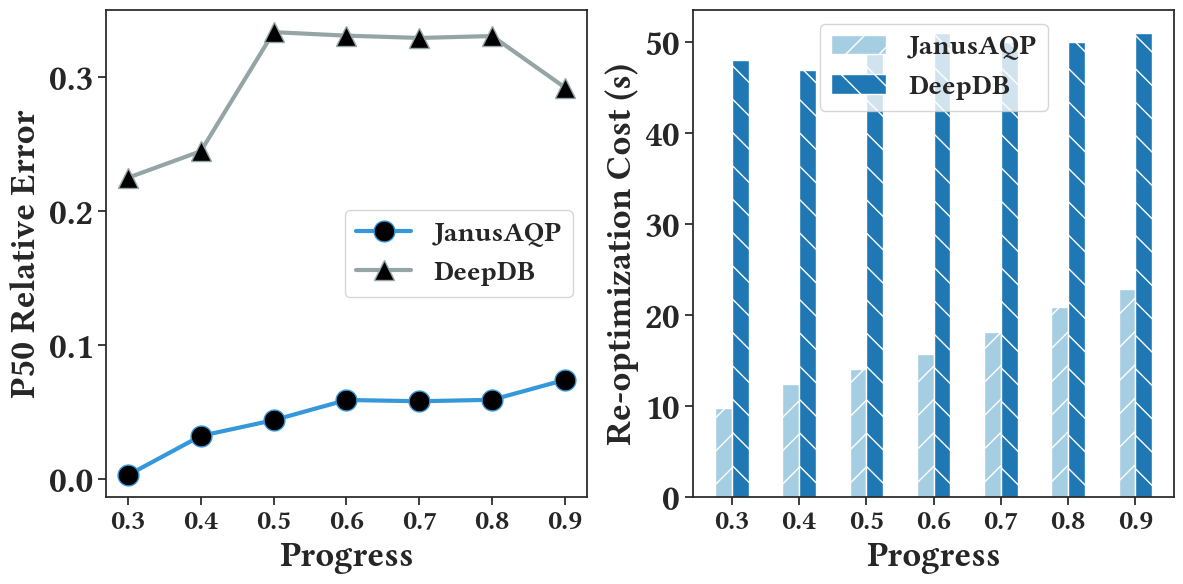

'LinLibertine_RB.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


In [97]:

largs = dict(results=baseperf,

             ticks=[x/10 for x in range(3, 10)], 
             xlabel="Progress", 
             ylabel="P50 Relative Error"
            )

rargs = dict(results=costs,

             ticks=[x/10 for x in range(3, 10)], 
             xlabel="Progress", 
             ylabel="Re-optimization Cost (s)")

plot2(largs, linesubplot, rargs, kbarsubplot, fname="end2end-etf-2k-p50re-cost-256")